In [1]:
using TCI4Keldysh
using PythonCall
using PythonPlot
using HDF5
using MAT

In [2]:
# check full Keldysh vertex

channel = "t"
flavor_idx = 1

basepath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50")
PSFpath = joinpath(basepath, "PSF_nz=4_conn_zavg/")
Vpath = joinpath(basepath, "V_KF_$(TCI4Keldysh.channel_translate(channel))")

T = TCI4Keldysh.dir_to_T(PSFpath)

(γ, sigmak) = TCI4Keldysh.read_broadening_params(basepath; channel=channel)
broadening_kwargs = TCI4Keldysh.read_broadening_settings(joinpath(TCI4Keldysh.datadir(), basepath); channel=channel)
if !haskey(broadening_kwargs, "estep")
    broadening_kwargs[:estep] = 20
end


20

In [3]:
MuNRGpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50", "V_KF_$(TCI4Keldysh.channel_translate(channel))")

function adjust_matdata(data::Array)
    out = permutedims(data, (4,5,6,7,3,1,2))
    out = reverse(out; dims=(7,5,6))
    return out
end

function _readMAT!(filename; flavor_idx::Int=1)
    out = nothing
    matopen(joinpath(MuNRGpath, filename)) do f
        CFdat = read(f, "CFdat")
        out = CFdat["Ggrid"][flavor_idx]
        out = adjust_matdata(out)
    end
    return out
end
function _readMATgrid(filename)
    grid = nothing
    matopen(joinpath(MuNRGpath, filename)) do f
        CFdat = read(f, "CFdat")
        grid = CFdat["ogrid"]
    end
    return vec(grid)
end

_readMATgrid (generic function with 1 method)

### Compare K1

In [28]:
# Load MuNRG
refgrid = _readMATgrid("V_KF_U2_1.mat")
# t
K1tref = _readMAT!("V_KF_U2_1.mat"; flavor_idx=2)
# p
K1pref = _readMAT!("V_KF_U2_2.mat"; flavor_idx=2)
# a
K1aref = _readMAT!("V_KF_U2_3.mat"; flavor_idx=2)
nothing

In [34]:
# Load Julia, nonlinear grid
nonlin_upup = joinpath(TCI4Keldysh.pdatadir(), "pwtcidata_updown", "V_KF.h5")
K1a = h5read(nonlin_upup, "K1a")
K1p = h5read(nonlin_upup, "K1pNRG")
K1t = h5read(nonlin_upup, "K1t")
loggrid = h5read(joinpath(TCI4Keldysh.pdatadir(), "loggrid2.h5"), "om1")
nothing

In [35]:
# Load Julia, linear grid, blockwise evaluation
@show size(K1p)
@show size(K1pref)

size(K1p) = (2, 2, 2, 2, 17, 17, 17)
size(K1pref) = (2, 2, 2, 2, 201, 201, 201)


(2, 2, 2, 2, 201, 201, 201)

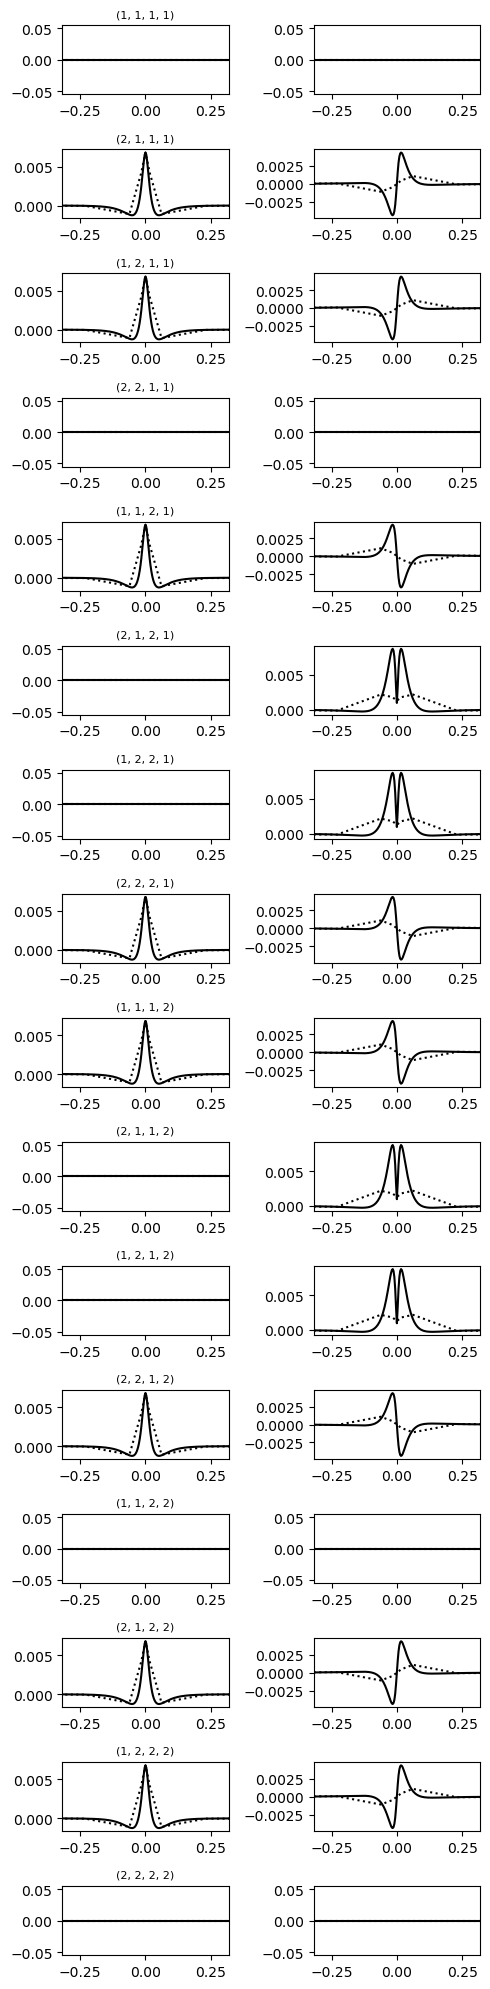

(minimum(loggrid), maximum(loggrid)) = (-3.183098861837906, 3.183098861837906)
(minimum.(refgrid), maximum.(refgrid)) = ([-0.3183098861837907, -0.3183098861837907, -0.3183098861837907], [0.3183098861837907, 0.3183098861837907, 0.3183098861837907])


In [50]:
# Compare
@show (minimum(loggrid), maximum(loggrid))
@show (minimum.(refgrid), maximum.(refgrid))

fig, ax = subplots(16,2; figsize=(5,20))

xlims = (minimum(refgrid[1]), maximum(refgrid[1]))
K1 = K1t
K1ref = K1tref
mid = 9
midref = 101
slice = (Colon(),mid,mid)
sliceref = (Colon(),midref,midref)
for iK in 0:15
    iktuple = TCI4Keldysh.KF_idx(iK+1, 3)
    # real part
        ax[iK, 0].plot(refgrid[1], real.(K1ref[iktuple...,sliceref...]); color="black")
        ax[iK, 0].plot(loggrid, real.(K1[iktuple...,slice...]); color="black", linestyle="dotted")
        ax[iK,0].set_title("$iktuple"; fontsize=8)
    # imaginary part
        ax[iK, 1].plot(refgrid[1], imag.(K1ref[iktuple..., sliceref...]); color="black")
        ax[iK, 1].plot(loggrid, imag.(K1[iktuple..., slice...]); color="black", linestyle="dotted")
    # xlim
        ax[iK, 0].set_xlim(xlims)
        ax[iK, 1].set_xlim(xlims)
end

fig.tight_layout()
display(fig)


In [37]:
np = pyimport("numpy")

Python: <module 'numpy' from '/scratch/m/M.Frankenbach/tci4keldysh/.CondaPkg/env/lib/python3.11/site-packages/numpy/__init__.py'>

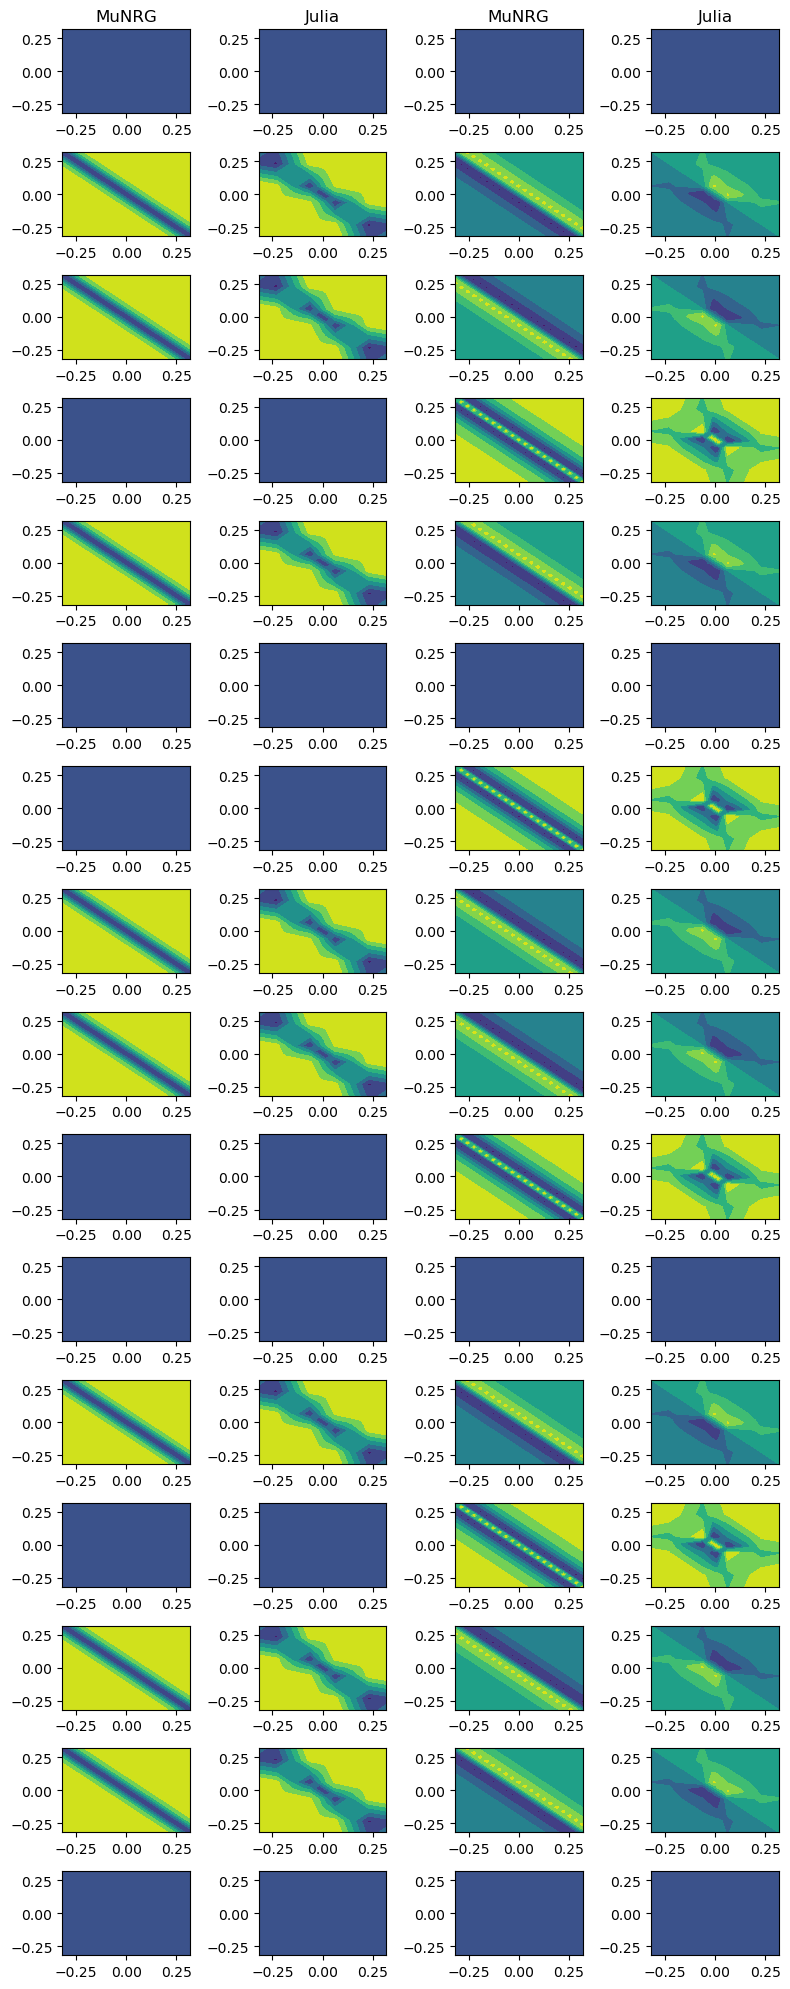

ref_window = [-0.3183098861837907, -0.2864788975654116, -0.25464790894703254, -0.22281692032865347, -0.19098593171027442, -0.15915494309189535, -0.12732395447351627, -0.09549296585513718, -0.06366197723675812, -0.03183098861837906, 0.0, 0.03183098861837906, 0.06366197723675812, 0.09549296585513718, 0.12732395447351627, 0.15915494309189535, 0.19098593171027442, 0.22281692032865347, 0.25464790894703254, 0.2864788975654116, 0.3183098861837907]
loggrid = [-3.183098861837906, -0.8539285932612233, -0.22908306466110148, -0.06145601743361306, -0.01648677995637913, -0.004422901526668035, -0.0011865299328528624, -0.0003183098861837908, 0.0, 0.0003183098861837908, 0.0011865299328528624, 0.004422901526668035, 0.01648677995637913, 0.06145601743361306, 0.22908306466110148, 0.8539285932612233, 3.183098861837906]


17-element Vector{Float64}:
 -3.183098861837906
 -0.8539285932612233
 -0.22908306466110148
 -0.06145601743361306
 -0.01648677995637913
 -0.004422901526668035
 -0.0011865299328528624
 -0.0003183098861837908
  0.0
  0.0003183098861837908
  0.0011865299328528624
  0.004422901526668035
  0.01648677995637913
  0.06145601743361306
  0.22908306466110148
  0.8539285932612233
  3.183098861837906

In [39]:

fig, ax = subplots(16,4; figsize=(8,20))

xlims = (minimum(refgrid[1]), maximum(refgrid[1]))
loglims = (minimum(loggrid), maximum(loggrid))
K1 = K1p
K1ref = K1pref
mid = 9
midref = 101
slice = (Colon(),Colon(),mid)
X, Y = np.meshgrid(loggrid, loggrid)
# min_id = findfirst(x -> abs(loglims[1]-x)<1.e-4, refgrid[1])
# max_id = findfirst(x -> abs(loglims[2]-x)<1.e-4, refgrid[1])
window_slice = 1:10:length(refgrid[1])
ref_window = refgrid[1][window_slice]
Xref, Yref = np.meshgrid(ref_window, ref_window)
sliceref = (window_slice, window_slice, midref)
for iK in 0:15
    iktuple = TCI4Keldysh.KF_idx(iK+1, 3)
    # real part
        ax[iK, 0].contourf(Xref, Yref, real.(K1ref[iktuple...,sliceref...]))
        ax[iK, 1].contourf(X, Y, real.(K1[iktuple...,slice...]))
        ax[iK, 1].set_xlim(xlims)
        ax[iK, 1].set_ylim(xlims)
    # imaginary part
        ax[iK, 2].contourf(Xref, Yref, imag.(K1ref[iktuple...,sliceref...]))
        ax[iK, 3].contourf(X, Y, imag.(K1[iktuple...,slice...]))
        ax[iK, 3].set_xlim(xlims)
        ax[iK, 3].set_ylim(xlims)
    # xlim
end
ax[0,0].set_title("MuNRG")
ax[0,1].set_title("Julia")
ax[0,2].set_title("MuNRG")
ax[0,3].set_title("Julia")

fig.tight_layout()
display(fig)
@show ref_window
@show loggrid

### Compare K2

#### K2 (noprime)

In [42]:
# Load Julia, nonlinear grid
nonlin_upup = joinpath(TCI4Keldysh.pdatadir(), "pwtcidata_updown", "V_KF.h5")
K2a = h5read(nonlin_upup, "K2a_noprime")
K2p = h5read(nonlin_upup, "K2pNRG_noprime")
K2t = h5read(nonlin_upup, "K2t_noprime")
loggrid = h5read(joinpath(TCI4Keldysh.pdatadir(), "loggrid2.h5"), "om1")
nothing

In [43]:
# Load MuNRG
refgrid = _readMATgrid("V_KF_U3_1.mat")
# t
K2tref = _readMAT!("V_KF_U3_6.mat"; flavor_idx=2)
# p
K2pref = _readMAT!("V_KF_U3_5.mat"; flavor_idx=2)
# a
K2aref = _readMAT!("V_KF_U3_4.mat"; flavor_idx=2)
nothing

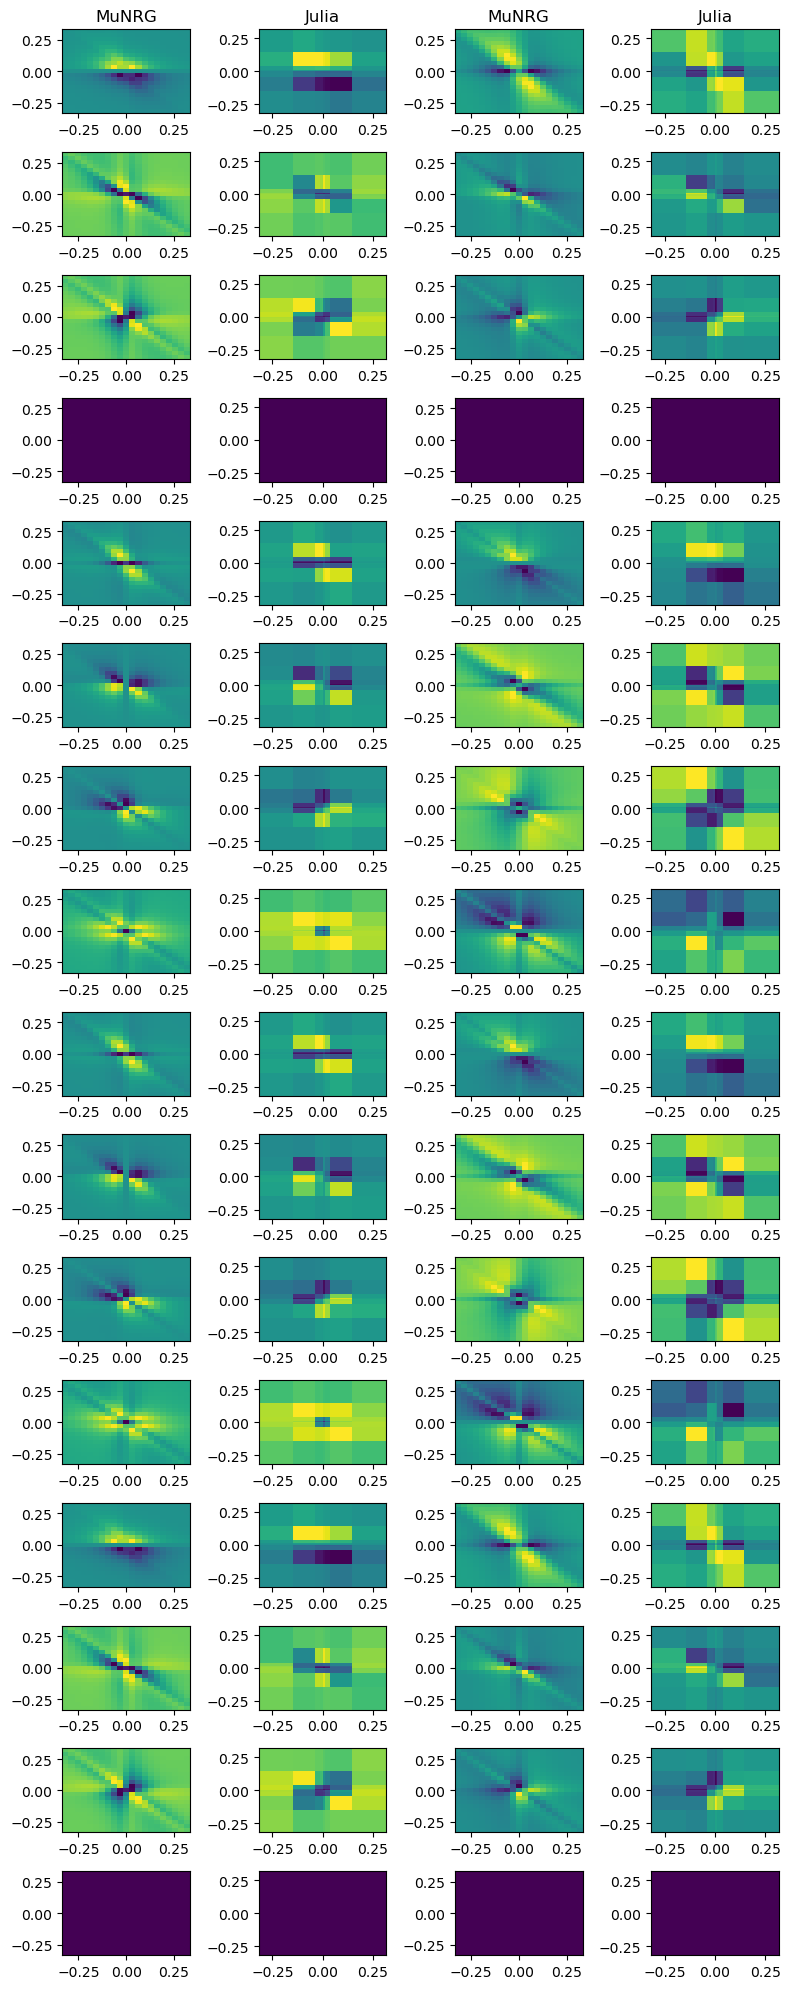

ref_window = [-0.3183098861837907, -0.2864788975654116, -0.25464790894703254, -0.22281692032865347, -0.19098593171027442, -0.15915494309189535, -0.12732395447351627, -0.09549296585513718, -0.06366197723675812, -0.03183098861837906, 0.0, 0.03183098861837906, 0.06366197723675812, 0.09549296585513718, 0.12732395447351627, 0.15915494309189535, 0.19098593171027442, 0.22281692032865347, 0.25464790894703254, 0.2864788975654116, 0.3183098861837907]
loggrid = [-3.183098861837906, -0.8539285932612233, -0.22908306466110148, -0.06145601743361306, -0.01648677995637913, -0.004422901526668035, -0.0011865299328528624, -0.0003183098861837908, 0.0, 0.0003183098861837908, 0.0011865299328528624, 0.004422901526668035, 0.01648677995637913, 0.06145601743361306, 0.22908306466110148, 0.8539285932612233, 3.183098861837906]


17-element Vector{Float64}:
 -3.183098861837906
 -0.8539285932612233
 -0.22908306466110148
 -0.06145601743361306
 -0.01648677995637913
 -0.004422901526668035
 -0.0011865299328528624
 -0.0003183098861837908
  0.0
  0.0003183098861837908
  0.0011865299328528624
  0.004422901526668035
  0.01648677995637913
  0.06145601743361306
  0.22908306466110148
  0.8539285932612233
  3.183098861837906

In [ ]:

fig, ax = subplots(16,4; figsize=(8,20))

xlims = (minimum(refgrid[1]), maximum(refgrid[1]))
loglims = (minimum(loggrid), maximum(loggrid))
K2 = K2t
K2ref = K2tref
mid = 9
midref = 101
slice = (Colon(),Colon(),mid)
X, Y = np.meshgrid(loggrid, loggrid)
# min_id = findfirst(x -> abs(loglims[1]-x)<1.e-4, refgrid[1])
# max_id = findfirst(x -> abs(loglims[2]-x)<1.e-4, refgrid[1])
window_slice = 1:10:length(refgrid[1])
ref_window = refgrid[1][window_slice]
Xref, Yref = np.meshgrid(ref_window, ref_window)
sliceref = (window_slice, window_slice, midref)
for iK in 0:15
    iktuple = TCI4Keldysh.KF_idx(iK+1, 3)
    # real part
        ax[iK, 0].pcolormesh(Xref, Yref, real.(K2ref[iktuple...,sliceref...]))
        ax[iK, 1].pcolormesh(X, Y, real.(K2[iktuple...,slice...]))
        ax[iK, 1].set_xlim(xlims)
        ax[iK, 1].set_ylim(xlims)
    # imaginary part
        ax[iK, 2].pcolormesh(Xref, Yref, imag.(K2ref[iktuple...,sliceref...]))
        ax[iK, 3].pcolormesh(X, Y, imag.(K2[iktuple...,slice...]))
        ax[iK, 3].set_xlim(xlims)
        ax[iK, 3].set_ylim(xlims)
    # xlim
end
ax[0,0].set_title("MuNRG")
ax[0,1].set_title("Julia")
ax[0,2].set_title("MuNRG")
ax[0,3].set_title("Julia")

fig.tight_layout()
display(fig)